In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import PyWGCNA
import os
import requests
import GEOparse # ต้องมี library นี้
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, f1_score
from boruta import BorutaPy 

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler

# --- Helper Function: STRING DB ---
def get_ppi_hubs_from_string(gene_list, species=9606, score_threshold=400, top_k=40):
    print(f"Querying STRING DB for {len(gene_list)} genes...")
    string_api_url = "https://string-db.org/api/tsv/network"
    params = {
        "identifiers": "%0d".join(gene_list),
        "species": species,
        "required_score": score_threshold,
        "caller_identity": "python_script"
    }
    try:
        response = requests.post(string_api_url, data=params)
        lines = response.text.strip().split("\n")
        if len(lines) < 2: return []
        edges = []
        for line in lines[1:]:
            parts = line.split("\t")
            if len(parts) > 2: edges.append((parts[2], parts[3]))
        
        G = nx.Graph()
        G.add_edges_from(edges)
        core_G = nx.k_core(G, k=2)
        if len(core_G.nodes()) == 0: core_G = G
        
        centrality = nx.degree_centrality(core_G)
        sorted_hubs = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        return [g for g, s in sorted_hubs[:top_k]]
    except: return []

In [2]:
# เปลี่ยน GSE ID ตามต้องการ แต่ในที่นี้คือ GSE66360
gse = GEOparse.get_GEO(geo="GSE66360", destdir="./")
print("Data Loaded.")

# ดึงข้อมูล Expression Matrix ออกมา
# gse.pivot_samples('VALUE') จะให้ DataFrame ที่ index=ProbeID, columns=SampleID
exprsdata = gse.pivot_samples('VALUE')
print(f"Raw Data Shape: {exprsdata.shape}")

02-Feb-2026 13:05:40 DEBUG utils - Directory ./ already exists. Skipping.
02-Feb-2026 13:05:40 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE66nnn/GSE66360/soft/GSE66360_family.soft.gz to ./GSE66360_family.soft.gz
100%|██████████| 68.5M/68.5M [00:38<00:00, 1.89MB/s]  
02-Feb-2026 13:06:21 DEBUG downloader - Size validation passed
02-Feb-2026 13:06:21 DEBUG downloader - Moving C:\Users\surap\AppData\Local\Temp\tmpmw7pgx8m to d:\Workspace_PC\AIBI_Analytic_Tools\notebooks\GSE66360_family.soft.gz
02-Feb-2026 13:06:21 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE66nnn/GSE66360/soft/GSE66360_family.soft.gz
02-Feb-2026 13:06:21 INFO GEOparse - Parsing ./GSE66360_family.soft.gz: 
02-Feb-2026 13:06:21 DEBUG GEOparse - DATABASE: GeoMiame
02-Feb-2026 13:06:21 DEBUG GEOparse - SERIES: GSE66360
02-Feb-2026 13:06:21 DEBUG GEOparse - PLATFORM: GPL570
02-Feb-2026 13:06:22 DEBUG GEOparse - SAMPLE: GSM1620819
02-Feb-2026 13:06:22 DEBUG GEOpar

Data Loaded.
Raw Data Shape: (54675, 99)


In [11]:
print("--- Step 0: Data Prep & Max Probe Aggregation (Fix) ---")

# 1. เตรียมรายชื่อ Control Sample
try:
    control_ids_list = gse.phenotype_data[
        gse.phenotype_data['title'].str.contains('Control', case=False)
    ]['geo_accession'].tolist()
    print(f"Identified {len(control_ids_list)} Control samples.")
except:
    print("Warning: Metadata not found, using column names.")
    control_ids_list = []

# 2. ฟังก์ชันโหลด Probe Map
def load_probe_dict(file_path):
    probe_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                probe_dict[parts[1]] = parts[2]
    return probe_dict

# *** ตรวจสอบ Path ไฟล์ probe2gene.txt ของคุณให้ถูกต้อง ***
probe_file_path = r'D:\Workspace_PC\AIBI_Analytic_Tools\data\processed\probe2gene.txt'

if os.path.exists(probe_file_path):
    print("Loading probe map...")
    probe_map = load_probe_dict(probe_file_path)
    
    # --- AUTO-DETECT ORIENTATION (แก้ปัญหาข้อมูลกลับหัว) ---
    # เราต้องการ (Probes x Samples) เพื่อ map index
    if exprsdata.shape[0] < exprsdata.shape[1]: 
        print(f"Transposing data to format (Probes x Samples)...")
        data_probes = exprsdata.T
    else:
        data_probes = exprsdata.copy()
        
    # Map ชื่อ Gene
    data_probes['Gene_Symbol'] = data_probes.index.map(probe_map)
    data_clean = data_probes.dropna(subset=['Gene_Symbol'])
    
    # MAX AGGREGATION (กู้ LILRA1)
    print("Aggregating probes using MAX strategy...")
    data = data_clean.groupby('Gene_Symbol').max()
    print(f"Final Data Shape: {data.shape} (Genes x Samples)")
    
else:
    raise FileNotFoundError("Probe file not found! Please check path.")

# 3. สร้าง sample_classes
sample_classes = []
for col in data.columns:
    col_str = str(col) # แก้ Error int iterable
    if col_str in control_ids_list or 'Control' in col_str or 'control' in col_str:
        sample_classes.append(1) # Control
    else:
        sample_classes.append(2) # Treated

sample_classes = np.array(sample_classes)
print(f"Class Distribution: {np.unique(sample_classes, return_counts=True)}")

# เช็คสัญญาณ LILRA1
if 'LILRA1' in data.index:
    c_mean = data.loc['LILRA1', sample_classes==1].mean()
    t_mean = data.loc['LILRA1', sample_classes==2].mean()
    print(f"LILRA1 Diff: {t_mean - c_mean:.4f}")

--- Step 0: Data Prep & Max Probe Aggregation (Fix) ---
Identified 50 Control samples.
Loading probe map...
Aggregating probes using MAX strategy...
Final Data Shape: (20626, 99) (Genes x Samples)
Class Distribution: (array([1, 2]), array([50, 49]))
LILRA1 Diff: 1.1110



--- Step 1 & 2: DEGs + WGCNA (Unbiased - Single Best Module) ---
Found 1493 Significant DEGs.
Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  5000
    Power  SFT.R.sq     slope truncated R.sq      mean(k)   median(k)  \
0       1  0.075329  0.201854       -0.14536  1008.159753  851.194367   
1       2  0.428476 -0.479351       0.314085   526.154697   396.12258   
2       3  0.592072 -0.822977       0.519215   316.799428  204.946448   
3       4  0.621675 -1.007687        0.56444   207.668136  110.037855   
4       5  0.687766 -1.072567       0.638667   144.263836   61.325448   
5       6  0.723991 -1.098348       0.685887   104.595653   35.906272   
6       7  0.760138 -1.089055        0.72809    78.383012   21.646484   
7       8   0.79529  -1.08247       0.770712    60.311166   13.438399   
8       9  0.846998 -1.053621       0.8267

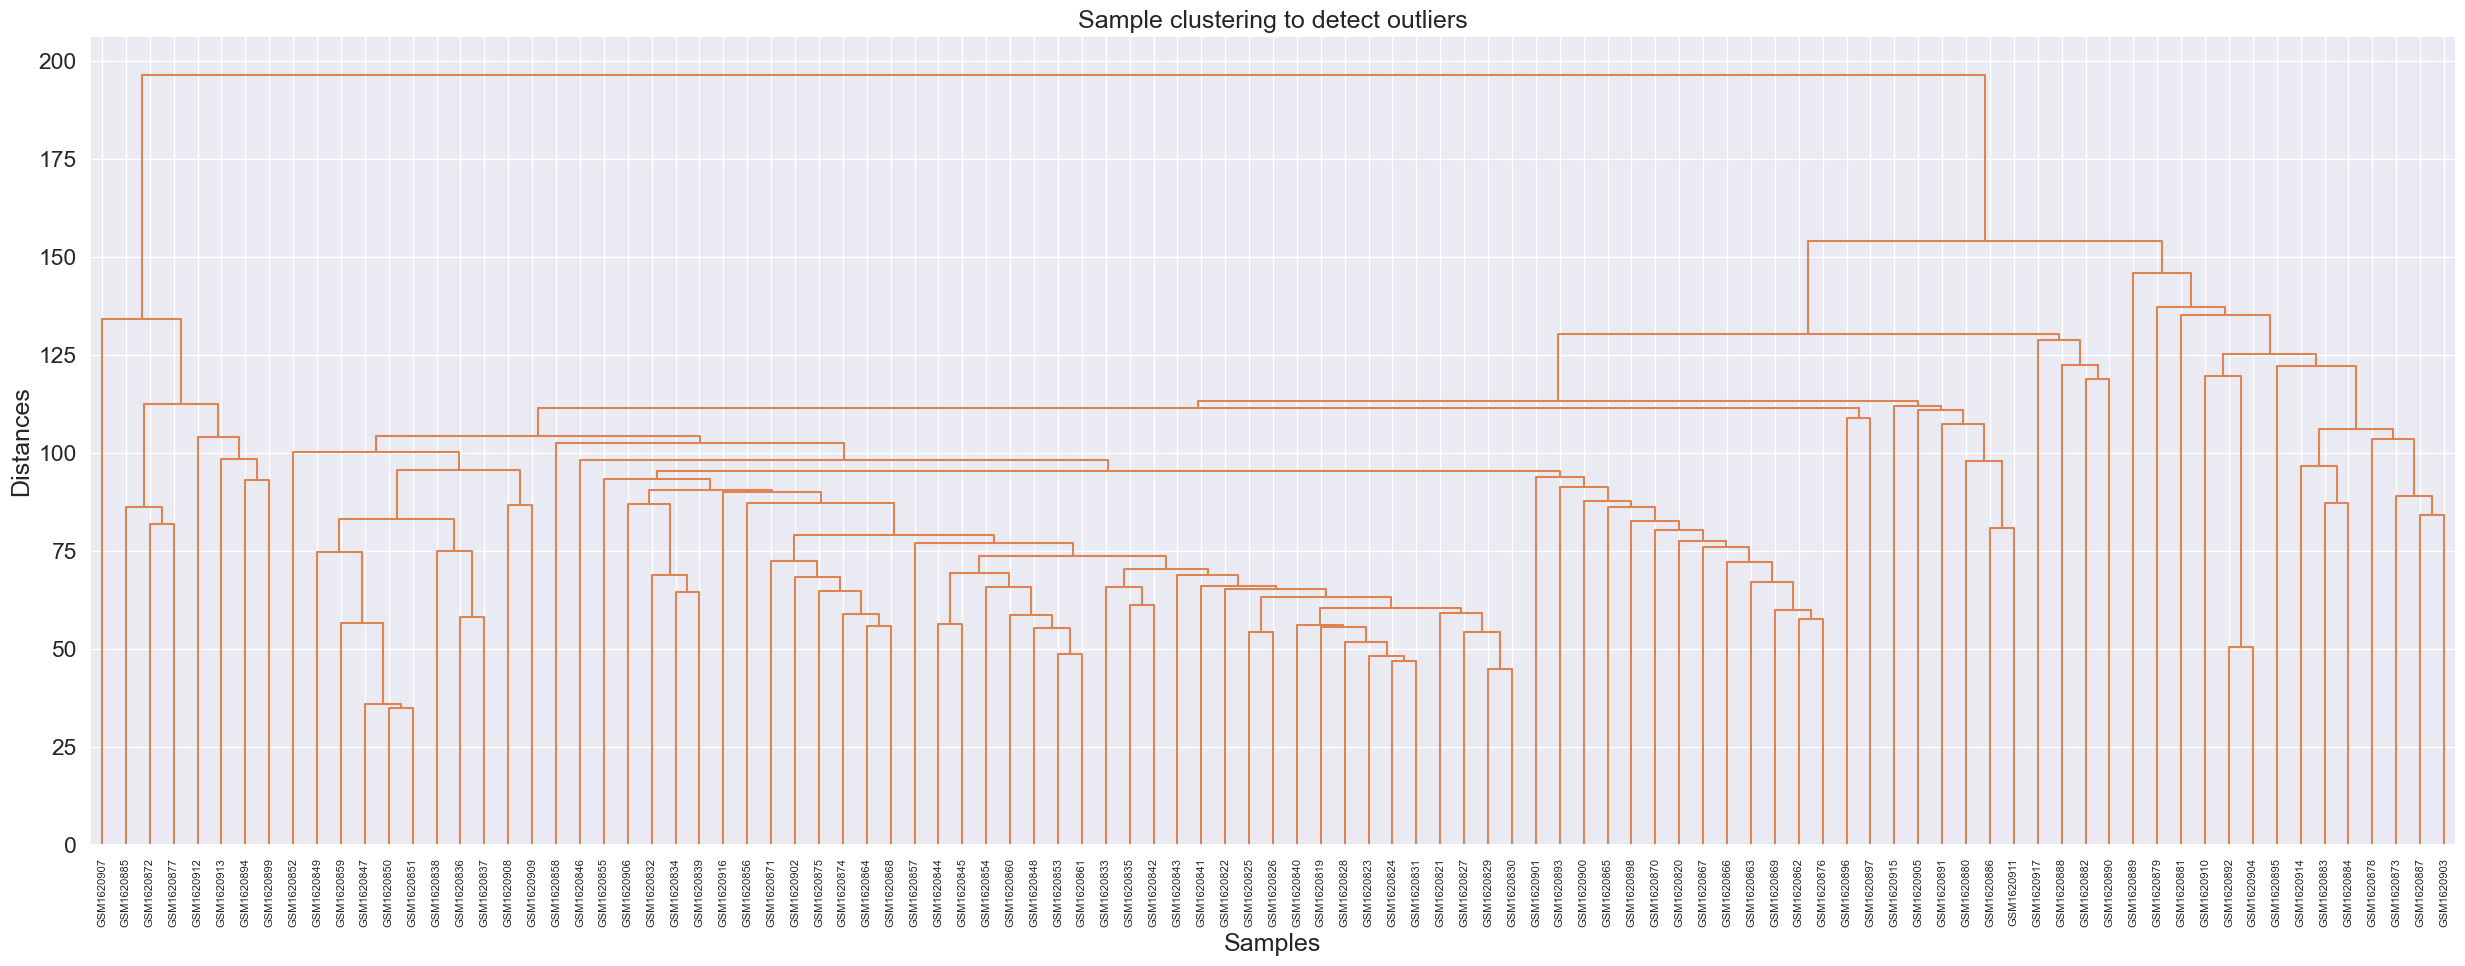

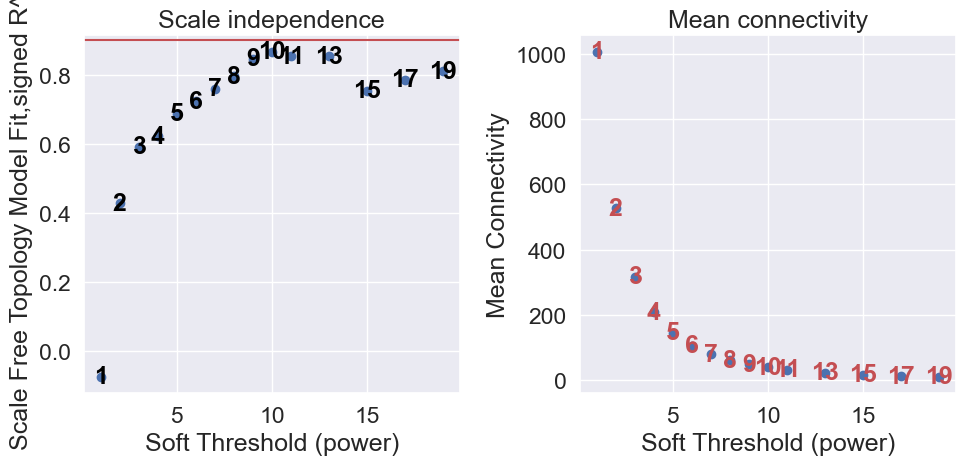

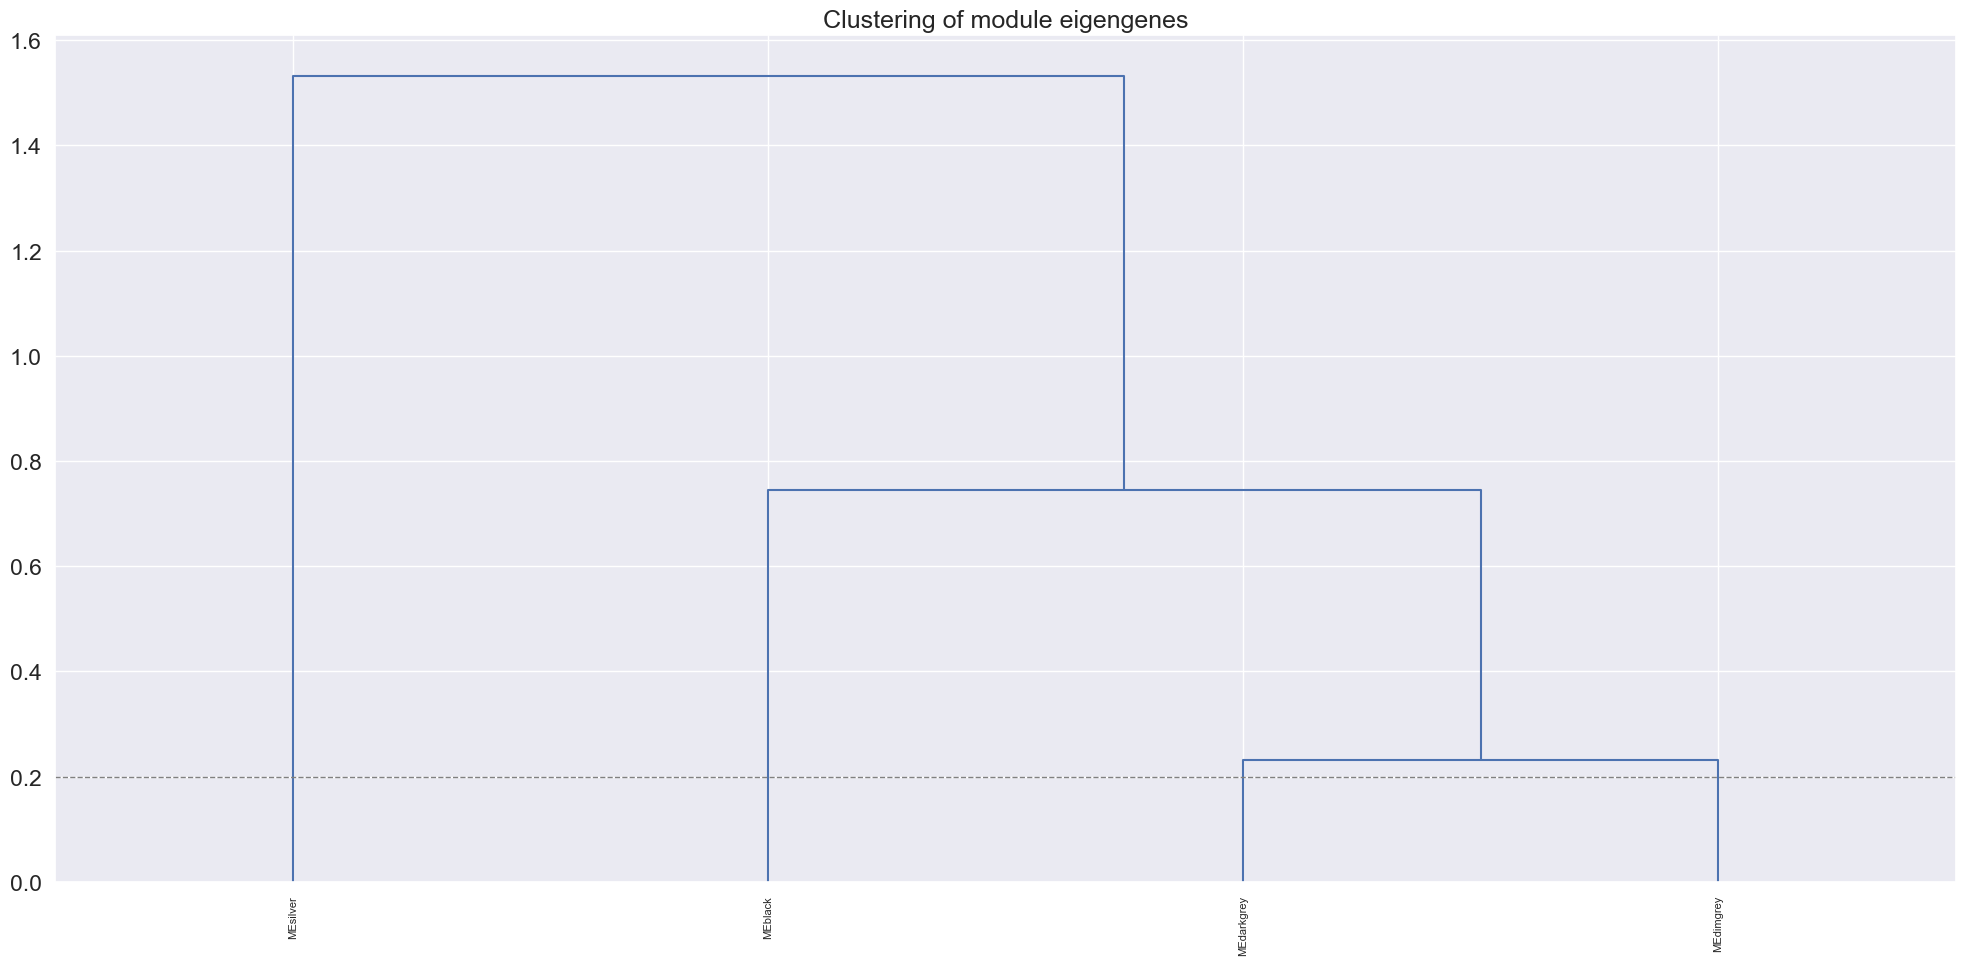

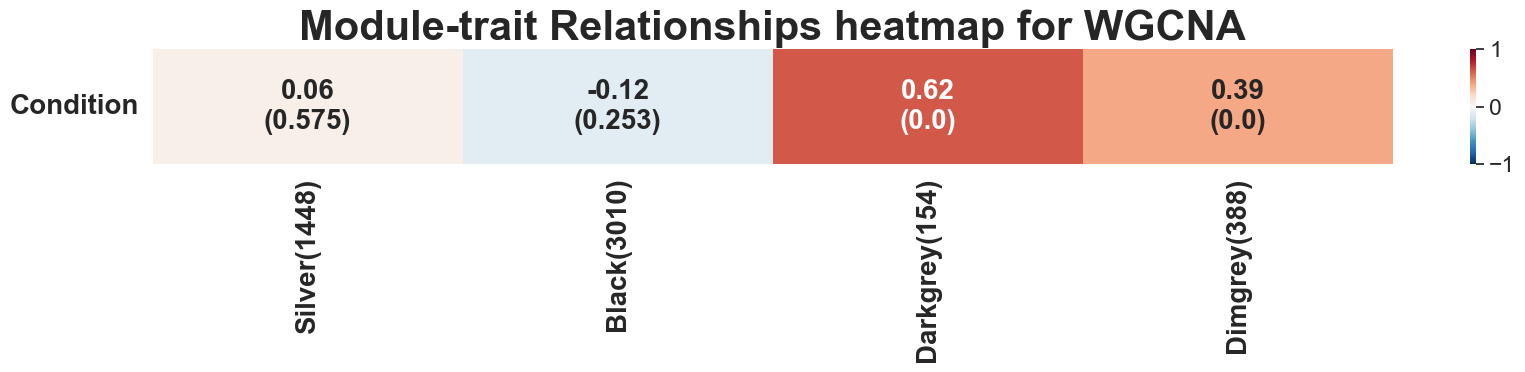

In [26]:
print("\n--- Step 1 & 2: DEGs + WGCNA (Unbiased - Single Best Module) ---")

# ==========================================
# 1. DEGs Analysis
# ==========================================
control_mask = (sample_classes == 1)
treated_mask = (sample_classes == 2)
p_values, log_fc = [], []
X_val = data.values

for i in range(X_val.shape[0]):
    c_data, t_data = X_val[i, control_mask], X_val[i, treated_mask]
    _, p = stats.ttest_ind(t_data, c_data, equal_var=False)
    p_values.append(p)
    log_fc.append(np.mean(t_data) - np.mean(c_data))

_, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
degs_df = pd.DataFrame({'logFC': log_fc, 'Adj_P': pvals_corrected}, index=data.index)
sig_degs = degs_df[(degs_df['Adj_P'] < 0.05) & (abs(degs_df['logFC']) > 0.5)]
print(f"Found {len(sig_degs)} Significant DEGs.")

# ==========================================
# 2. WGCNA Analysis (Single Best Module)
# ==========================================
geneExp = data.T
target_n_genes = 5000
if geneExp.shape[1] > target_n_genes:
    top_genes = geneExp.var().sort_values(ascending=False).head(target_n_genes).index
    geneExp = geneExp[top_genes]

trait_data = pd.DataFrame({'Condition': np.where(sample_classes == 2, 1, 0)}, index=data.columns).loc[geneExp.index]

# Run WGCNA
pyWGCNA_obj = PyWGCNA.WGCNA(geneExp=geneExp, outputPath="wgcna_results")
pyWGCNA_obj.preprocess()
pyWGCNA_obj.findModules()
pyWGCNA_obj.updateSampleInfo(trait_data)
pyWGCNA_obj.analyseWGCNA()

# --- SELECT SINGLE BEST MODULE ---
best_module_genes = []
try:
    mod_trait = pyWGCNA_obj.moduleTraitCor
    if 'Condition' in mod_trait.columns:
        # 1. เรียงลำดับ Module ตามค่า Abs Correlation (มาก -> น้อย)
        sorted_modules = mod_trait['Condition'].abs().sort_values(ascending=False)
        
        # 2. กรองเอา MEgrey (ขยะ) ออกไป
        valid_modules = [m for m in sorted_modules.index if m != 'MEgrey']
        
        if len(valid_modules) > 0:
            # 3. เลือกอันดับ 1 (The Winner)
            best_me = valid_modules[0]
            target_color = best_me.replace("ME", "")
            max_corr = mod_trait.loc[best_me, 'Condition']
            
            print(f"\n[Unbiased Selection] The Best Module is '{target_color}' (Corr: {max_corr:.4f})")
            
            # 4. ดึงยีนจาก Module นี้
            gene_map = pyWGCNA_obj.datExpr.var
            best_module_genes = gene_map.index[gene_map['moduleColors'] == target_color].tolist()
            print(f"Selected {len(best_module_genes)} genes from '{target_color}'.")
            
        else:
            print("Error: No valid modules found (all were grey?).")
    else:
        print("Error: Condition trait not found.")
except Exception as e:
    print(f"Error selecting module: {e}")

In [27]:
print("\n--- Step 3 & 4: Intersection & Voting (Pure Data-Driven) ---")

# ==========================================
# 3. Intersection & PPI
# ==========================================
# 1. Intersection (DEGs & WGCNA from Top 2 Modules)
# ตัวแปร best_module_genes ตอนนี้มียีนจากทั้ง 2 สีรวมกันแล้ว
candidate_genes = list(set(sig_degs.index) & set(best_module_genes))

# Fallback: ถ้า Intersect แล้วเหลือน้อย (เพราะเงื่อนไข DEGs อาจจะโหดไป) ให้ใช้ Union
if len(candidate_genes) < 10:
    print("Intersection small. Using Union of Top DEGs & Module Genes.")
    candidate_genes = list(set(sig_degs.head(100).index) | set(best_module_genes[:100]))

print(f"Candidates for PPI: {len(candidate_genes)}")

# 2. STRING DB Filter
top_hub_genes = []
if len(candidate_genes) > 0:
    # เรียกฟังก์ชัน STRING (ดึง Top 50 Hubs)
    raw_hub_genes = get_ppi_hubs_from_string(candidate_genes[:500], top_k=50)
    
    # Safety Filter: กรองเฉพาะยีนที่มีใน Data เท่านั้น
    top_hub_genes = [g for g in raw_hub_genes if g in data.index]
    print(f"STRING returned {len(raw_hub_genes)} hubs -> {len(top_hub_genes)} valid in dataset.")
    
    # Fallback
    if len(top_hub_genes) == 0: 
        print("Warning: STRING filter empty. Using original top candidates.")
        top_hub_genes = candidate_genes[:50]
else:
    top_hub_genes = []

# ==========================================
# 4. Feature Selection: 3-Model Voting (Pure Data-Driven)
# ==========================================
# ใช้ยีนจาก Step 3 เป็นสารตั้งต้น
target_genes_pool = top_hub_genes if len(top_hub_genes) > 0 else candidate_genes

if len(target_genes_pool) > 0:
    X_ml = data.loc[target_genes_pool].T
    y_ml = np.where(sample_classes == 2, 1, 0)
    
    print(f"\nRunning 3-Model Voting on {len(target_genes_pool)} features...")
    
    # 1. LASSO
    try:
        lasso = LassoCV(cv=5, random_state=42, max_iter=50000).fit(X_ml, y_ml)
        lasso_genes = X_ml.columns[lasso.coef_ != 0].tolist()
    except: lasso_genes = []
    print(f" - LASSO selected: {len(lasso_genes)}")

    # 2. SVM-RFE
    try:
        svc = SVC(kernel="linear", C=1)
        # เลือก 20 ตัวที่ดีที่สุด (หรือทั้งหมดถ้ามีน้อยกว่า)
        n_sel = min(20, len(target_genes_pool))
        rfe = RFE(estimator=svc, n_features_to_select=n_sel, step=1)
        rfe.fit(X_ml, y_ml)
        svm_genes = X_ml.columns[rfe.support_].tolist()
    except: svm_genes = []
    print(f" - SVM-RFE selected: {len(svm_genes)}")

    # 3. Random Forest
    try:
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_ml, y_ml)
        imp = pd.Series(rf.feature_importances_, index=X_ml.columns)
        rf_genes = imp[imp > imp.mean()].index.tolist()
    except: rf_genes = []
    print(f" - Random Forest selected: {len(rf_genes)}")

    # --- FINAL VOTING (Majority Vote >= 2) ---
    from collections import Counter
    counts = Counter(lasso_genes + svm_genes + rf_genes)
    final_biomarkers = [g for g, c in counts.items() if c >= 2]
    
    # Fallback: ถ้าโหวตแล้วเหลือยีนน้อยเกินไป ให้ใช้ Union แทน
    if len(final_biomarkers) < 2:
        print("Majority vote too strict. Taking Union of all models.")
        final_biomarkers = list(set(lasso_genes) | set(svm_genes) | set(rf_genes))

    print(f"[FINAL] System Identified {len(final_biomarkers)} Biomarkers: {final_biomarkers}")

else:
    print("No genes available for Feature Selection.")
    final_biomarkers = []


--- Step 3 & 4: Intersection & Voting (Pure Data-Driven) ---
Candidates for PPI: 137
Querying STRING DB for 137 genes...
STRING returned 50 hubs -> 49 valid in dataset.

Running 3-Model Voting on 49 features...
 - LASSO selected: 23
 - SVM-RFE selected: 20
 - Random Forest selected: 14
[FINAL] System Identified 19 Biomarkers: ['ICAM1', 'CXCL1', 'ITGAX', 'S100A12', 'CXCL2', 'CXCR2', 'CCL20', 'FCGR2A', 'NCF2', 'GZMB', 'IL1R2', 'FOSB', 'NFIL3', 'ALOX5', 'DDIT3', 'NR4A2', 'BCL3', 'EREG', 'NLRP3']



--- Step 5: Validation (Final Report) ---
Accuracy: 0.8788
F1 Score: 0.8776
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        50
           1       0.88      0.88      0.88        49

    accuracy                           0.88        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.88      0.88      0.88        99

Mean AUC: 0.9848


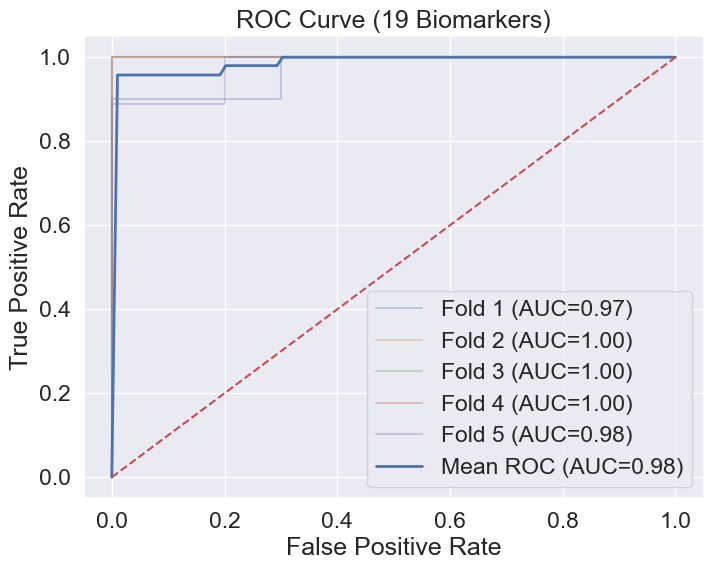

In [28]:
print("\n--- Step 5: Validation (Final Report) ---")

if len(final_biomarkers) > 0:
    X_final = data.loc[final_biomarkers].T
    y_final = np.where(sample_classes == 2, 1, 0)

    # Voting Classifier
    eclf = VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('svm', SVC(probability=True, kernel='linear', random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ], voting='soft')

    # Cross Validation
    y_pred = cross_val_predict(eclf, X_final, y_final, cv=5)
    
    # Report Metrics
    acc = accuracy_score(y_final, y_pred)
    f1 = f1_score(y_final, y_pred) # เพิ่มบรรทัดนี้
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}") # เพิ่มบรรทัดนี้
    print(classification_report(y_final, y_pred))
    
    # Plot ROC
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(8,6))
    for i, (train, test) in enumerate(cv.split(X_final, y_final)):
        model = eclf.fit(X_final.iloc[train], y_final[train])
        probas_ = model.predict_proba(X_final.iloc[test])
        fpr, tpr, _ = roc_curve(y_final[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i+1} (AUC={roc_auc:.2f})') # โชว์ AUC ของแต่ละ Fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    print(f"Mean AUC: {mean_auc:.4f}") # เพิ่มบรรทัดนี้
    
    plt.plot(mean_fpr, mean_tpr, 'b', lw=2, label=f'Mean ROC (AUC={mean_auc:.2f})')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({len(final_biomarkers)} Biomarkers)')
    plt.legend(loc="lower right")
    plt.show()

else:
    print("No biomarkers selected.")


--- Step 6: Hyperparameter Tuning (Grid Search) ---
Optimizing models on 19 features...
Searching for best Random Forest params...
 -> Best RF: {'class_weight': None, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Searching for best SVM params...
 -> Best SVM: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Searching for best Gradient Boosting params...
 -> Best GB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}

Building Final Optimized Ensemble...

--- OPTIMIZED RESULTS ---
Accuracy: 0.8990
F1 Score: 0.8958
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        50
           1       0.91      0.88      0.90        49

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99

Optimized Mean AUC: 0.9661


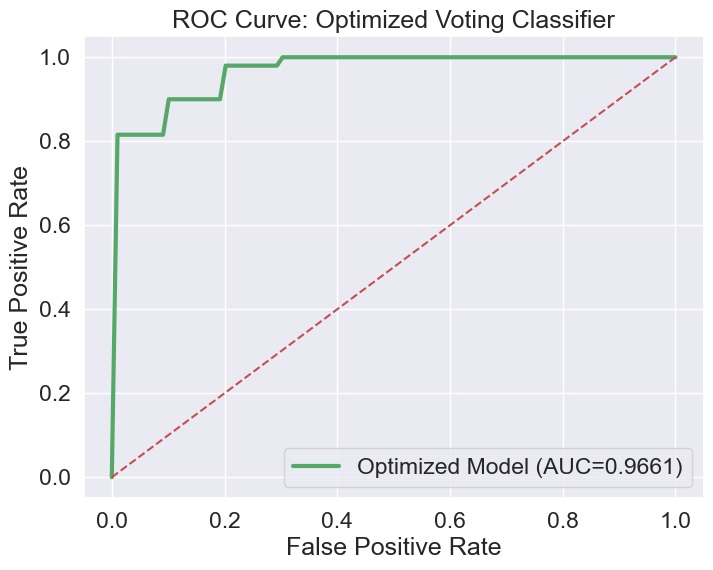

In [29]:
from sklearn.model_selection import GridSearchCV

print("\n--- Step 6: Hyperparameter Tuning (Grid Search) ---")

if len(final_biomarkers) > 0:
    # เตรียมข้อมูล (เฉพาะ Features ที่คัดมาแล้ว)
    X_final = data.loc[final_biomarkers].T
    y_final = np.where(sample_classes == 2, 1, 0)
    
    print(f"Optimizing models on {X_final.shape[1]} features...")

    # ==========================================
    # 1. Define Parameter Grids (ตารางที่จะให้คอมสุ่มหา)
    # ==========================================
    # RF: ลองเปลี่ยนจำนวนต้นไม้ และความลึก
    rf_params = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', None]
    }
    
    # SVM: ลองเปลี่ยนค่า C (ความเข้มงวด) และ Kernel
    svm_params = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['linear', 'rbf'] # Linear หรือ RBF ดีกว่ากัน?
    }
    
    # GB: ลองเปลี่ยน Learning Rate (การเรียนรู้)
    gb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

    # ==========================================
    # 2. Run Grid Search (เริ่มค้นหาค่าที่ดีที่สุด)
    # ==========================================
    # สร้าง Cross-Validation แบบ Stratified เพื่อความแฟร์
    cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("Searching for best Random Forest params...")
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=cv_strat, n_jobs=-1, scoring='accuracy')
    grid_rf.fit(X_final, y_final)
    best_rf = grid_rf.best_estimator_
    print(f" -> Best RF: {grid_rf.best_params_}")

    print("Searching for best SVM params...")
    grid_svm = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=cv_strat, n_jobs=-1, scoring='accuracy')
    grid_svm.fit(X_final, y_final)
    best_svm = grid_svm.best_estimator_
    print(f" -> Best SVM: {grid_svm.best_params_}")

    print("Searching for best Gradient Boosting params...")
    grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=cv_strat, n_jobs=-1, scoring='accuracy')
    grid_gb.fit(X_final, y_final)
    best_gb = grid_gb.best_estimator_
    print(f" -> Best GB: {grid_gb.best_params_}")

    # ==========================================
    # 3. Final Voting with OPTIMIZED Models
    # ==========================================
    print("\nBuilding Final Optimized Ensemble...")
    
    # ใช้โมเดลร่างทอง (Best Estimators) มารวมร่างกัน
    eclf_opt = VotingClassifier(estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('gb', best_gb)
    ], voting='soft')

    # ==========================================
    # 4. Final Validation (Optimized)
    # ==========================================
    # Cross Validation อีกรอบด้วยโมเดลที่จูนแล้ว
    y_pred_opt = cross_val_predict(eclf_opt, X_final, y_final, cv=5)
    
    acc_opt = accuracy_score(y_final, y_pred_opt)
    f1_opt = f1_score(y_final, y_pred_opt)
    
    print(f"\n--- OPTIMIZED RESULTS ---")
    print(f"Accuracy: {acc_opt:.4f}")
    print(f"F1 Score: {f1_opt:.4f}")
    print(classification_report(y_final, y_pred_opt))

    # Plot Comparison ROC
    plt.figure(figsize=(8,6))
    
    # Plot Optimized ROC
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    for i, (train, test) in enumerate(cv_strat.split(X_final, y_final)):
        model = eclf_opt.fit(X_final.iloc[train], y_final[train])
        probas_ = model.predict_proba(X_final.iloc[test])
        fpr, tpr, _ = roc_curve(y_final[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    print(f"Optimized Mean AUC: {mean_auc:.4f}")
    
    plt.plot(mean_fpr, mean_tpr, 'g', lw=3, label=f'Optimized Model (AUC={mean_auc:.4f})')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Optimized Voting Classifier')
    plt.legend(loc="lower right")
    plt.show()

else:
    print("No features to optimize.")